### Import Libraries

In [44]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, recall_score, precision_score, accuracy_score
from scipy.stats import mannwhitneyu, chi2_contingency
from xgboost import XGBClassifier
from xgboost import plot_importance

import warnings
warnings.filterwarnings('ignore')

### Read Data

In [45]:
path = os.getcwd() # Assuming the data and the notebook have the same path
df_thyroid = pd.read_csv(path + '/Thyroid_Diff.csv')

# Replace spaces by underscores in the columns' titles
df_thyroid.columns = df_thyroid.columns.str.replace(' ','_')

### Exploratory Data Analysis

In [46]:
# Check dimensions of the dataset
df_thyroid.shape

(383, 17)

In [47]:
# Check data types of features
df_thyroid.dtypes

Age                      int64
Gender                  object
Smoking                 object
Hx_Smoking              object
Hx_Radiothreapy         object
Thyroid_Function        object
Physical_Examination    object
Adenopathy              object
Pathology               object
Focality                object
Risk                    object
T                       object
N                       object
M                       object
Stage                   object
Response                object
Recurred                object
dtype: object

##### Duplicated Values

Given the problem, duplicated values are probably similar medical records of different individuals, so the duplicates won't be removed

##### Numerical Variables

In [48]:
# Check descriptive stats of numerical columns
df_thyroid.describe()

,Age
count,383.000000
mean,40.866841
std,15.134494
min,15.000000
25%,29.000000
50%,37.000000
75%,51.000000
max,82.000000


In [49]:
(df_thyroid['Age'].max() - df_thyroid['Age'].min())/5

13.4

In [50]:
round((df_thyroid['Age'].max() - df_thyroid['Age'].min())/5,0)

13.0

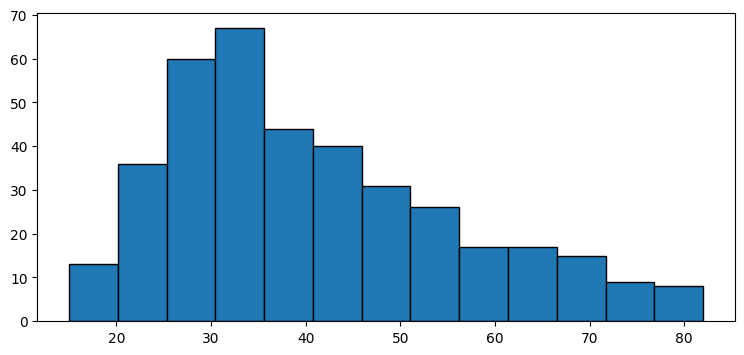

In [51]:
# Check age distribution
n_bins = int((df_thyroid['Age'].max() - df_thyroid['Age'].min())/5)
plt.figure(figsize = (9,4))
plt.hist(df_thyroid['Age'], bins=n_bins, edgecolor='black')
plt.show()

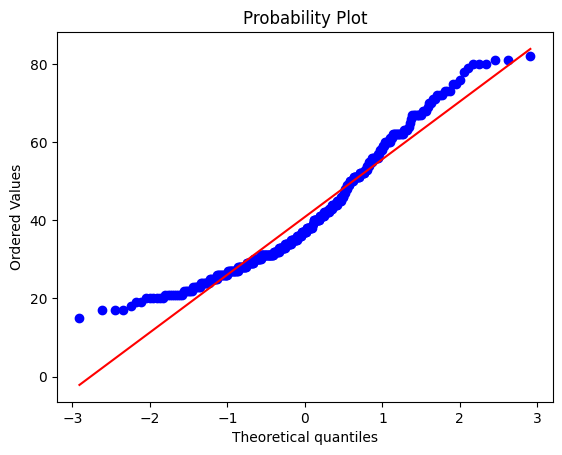

In [52]:
# QQ Plot 
fig, ax = plt.subplots()
stats.probplot(df_thyroid['Age'], dist="norm", plot=ax)
ax.get_lines()[1].set_color("red")

The two plots confirm that the variable 'Age' does not follow a normal distribution. On the QQ Plot, the data would fit the red line if it was normally distributed. This is important for statistical testing, model selection and scaling. However, decision tree models (Random Forest, XGBoost, ...) do not require scaling, nor do they require the variables to have a normal distribution.

##### Categorical Variables

In [53]:
# Find how many values can each object column assume
object_columns = df_thyroid.select_dtypes(include='object')

encodable_columns = {}
for col in object_columns.columns:
    unique_count = object_columns[col].nunique()
    total_count = len(df_thyroid)

    # We will just apply one-hot encoding to variables that have more than 2 possible values, since the others are already binary~
    if unique_count > 2: 
        encodable_columns[col] = unique_count

for col, unique_vals in encodable_columns.items():
    print(f"{col}: {unique_vals} unique values")

Thyroid_Function: 5 unique values
Physical_Examination: 5 unique values
Adenopathy: 6 unique values
Pathology: 4 unique values
Risk: 3 unique values
T: 7 unique values
N: 3 unique values
Stage: 5 unique values
Response: 4 unique values


##### Profile Report

This library provides an analysis on the variables and how they are correlated

In [54]:
report = ProfileReport(df_thyroid)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

The report concludes that the most important features are Adenopathy, N, Response, Risk and T

### Feature Engineering and Dataset splitting

In [55]:
# Shuffle the dataset in case it was sorted by some column
df_thyroid= df_thyroid.sample(frac=1, random_state=10).reset_index(drop=True)

We will split the dataset in train, validation and test set. We use the train set to tune the model, then the validation set to check the performance and decide if we should retune, and finally the test set is used as 'unseen' data

In [56]:
# Seperate features matrix from target vector
X = df_thyroid.iloc[:,:-1]
y = df_thyroid.iloc[:,-1:]

# Let's use 14% for the test size
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.14, random_state=10)
# And 14% of the other 90% for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.14, random_state=10)

In [57]:
# Function to transform target vector y from pandas dataframe to series
def y_series(y):
    y = y['Recurred']
    # Map 'No' to 0 and 'Yes' to 1
    y = y.map({'Yes': 1, 'No': 0}).astype(int)
    return y

y_train = y_series(y_train)
y_val = y_series(y_val)
y_test = y_series(y_test)

In [58]:
def significant_features(X_train, y_train, p_value_threshold=0.05):
    significant_features = []
    
    # Apply Mann-Whitney U test for 'age' (numerical and non-normally distributed)
    age_class_0 = X_train[y_train == 0]['Age']
    age_class_1 = X_train[y_train == 1]['Age']
    
    # Perform Mann-Whitney U test
    _, p_val = mannwhitneyu(age_class_0, age_class_1, alternative='two-sided')
    
    # Check if age is significant
    if p_val < p_value_threshold:
        significant_features.append('Age')
    
    # For each categorical feature
    for col in X_train.select_dtypes(include=['object', 'category']).columns:
        # Create a contingency table for the feature and the target
        contingency_table = pd.crosstab(X_train[col], y_train)
        
        # Perform Chi-square test
        _, p_val, _, _ = chi2_contingency(contingency_table)
        
        # Check if feature is significant
        if p_val < p_value_threshold:
            significant_features.append(col)
    
    return significant_features

In [59]:
keep_features = significant_features(X_train, y_train, p_value_threshold=0.05)
keep_features

['Age',
 'Gender',
 'Smoking',
 'Hx_Radiothreapy',
 'Adenopathy',
 'Pathology',
 'Focality',
 'Risk',
 'T',
 'N',
 'M',
 'Stage',
 'Response']

In [60]:
encodable_columns

{'Thyroid_Function': 5,
 'Physical_Examination': 5,
 'Adenopathy': 6,
 'Pathology': 4,
 'Risk': 3,
 'T': 7,
 'N': 3,
 'Stage': 5,
 'Response': 4}

According to the function, almost all features are significant. Features 'Hx_Smoking' and 'Thyroid_Function' will be removed from the dataset

In [61]:
X_train = X_train.loc[:,keep_features]
X_val = X_val.loc[:,keep_features]
X_test = X_test.loc[:,keep_features]

encodable_columns = {k: v for k, v in encodable_columns.items() if k in keep_features}

In [62]:
# Function to Encode categorical variables
def encode_df(X, all_columns=None):
    X = pd.get_dummies(X, columns=list(encodable_columns.keys()),dtype='int')
    X['Gender'] = X['Gender'].map({'F': 1, 'M': 0}).astype(int)
    X['Smoking'] = X['Smoking'].map({'Yes': 1, 'No': 0}).astype(int)
    X['Hx_Radiothreapy'] = X['Hx_Radiothreapy'].map({'Yes': 1, 'No': 0}).astype(int)
    X['Focality'] = X['Focality'].map({'Multi-Focal': 1, 'Uni-Focal': 0}).astype(int)
    X['M'] = X['M'].map({'M1': 1, 'M0': 0}).astype(int)

    X.columns = X.columns.str.replace(' ','_')

    # Ensure all datasets have the same columns
    if all_columns is not None:
        # Add missing columns with default value 0
        for col in all_columns:
            if col not in X.columns:
                X[col] = 0
        # Keep columns only in all_columns
        X = X[all_columns]

    return X

# Get all columns from a combined dataset for consistent encoding (Some of the datasets might not have certain values in some columns)
all_data = pd.concat([X_train, X_val, X_test], axis=0)
all_data_encoded = encode_df(all_data)
all_columns = all_data_encoded.columns

# Apply function to the datasets
X_train = encode_df(X_train, all_columns)
X_val = encode_df(X_val, all_columns)
X_test = encode_df(X_test, all_columns)

### Machine Learning Model Implementation

We will use XGBoost for classification for our model. <br> The evaluation metric used will be the recall because in this case False Negatives are a higher concern than False Positives: We would rather put patients with a slim chance of having recurrence under close monitorization than ignoring these patients at a risk of them having recurrences. Even if this risk is small for these individuals, the consequences could be dangerous.

In [63]:
# XGBoost for Classification
xgb_model = XGBClassifier()

# Grid Search to find the best parameters, without regularization
param_grid = {
    'max_depth': [1, 3, 5, 7],  
    'learning_rate': [0.01, 0.03, 0.1],  
    'n_estimators': [150, 350, 500, 800], 
}

# Since the data is imbalanced, we will use Stratified KFold
skf = StratifiedKFold(n_splits=6)

# Grid search with KFold validation, and adequate scoring given the evaluation method of the problem
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='recall', cv=skf, verbose=1, n_jobs=-1)

In [64]:
# Check scores when dividing training set into train and validation (before grid search)
scores = cross_val_score(xgb_model, X_train, y_train, cv=skf, scoring="recall")

# Print the Recall scores for each fold
print("Recall for each fold:", scores)
print("Mean Recall:", np.mean(scores))

Recall for each fold: [0.84615385 0.76923077 1.         0.92307692 0.92307692 1.        ]
Mean Recall: 0.9102564102564102


The first results appear to be good, even with default hyperparameters. Let's add a grid search to find more suitable hyperparameters

In [65]:
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

Fitting 6 folds for each of 48 candidates, totalling 288 fits


In [66]:
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=800, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Here we use .predict to get a binary outcome. We could also do something like the commented code to get a continuous outcome, and then set a threshold (which can be lower than 0.5 if we want to be more conservative) to separate the 0 from the 1 in the outcome prediction

In [67]:
y_pred_train = best_model.predict(X_train)
recall_score(y_train,y_pred_train)

# y_pred_train_cont = best_model.predict_proba(X_train)[:,1]
# threshold = 0.4
# y_pred_train_binary = np.where(y_pred_train_cont > 0.4, 1, 0)
# recall_score(y_train,y_pred_train_binary)

0.9620253164556962

Let's do a second grid search with regularization to try to make the model generalize better to unseen data. Usually the training score gets penalized in hope of a better testing score. Add or remove values to the grid search for a computing time - performance trade off 

In [68]:
reg = {
    'min_child_weight': [3, 5, 10],  
    'subsample': [0.6, 0.8, 1.0],  
    'colsample_bytree': [0.75, 0.95],  
    'colsample_bylevel': [0.75, 0.95],  
    'reg_alpha': [0.1, 0.5, 1.0],  
    'reg_lambda': [0.5, 1.0, 3.0],  
    'gamma': [0.3, 1.0, 3.0] 
}
params_reg = {key: [value] for key, value in grid_search.best_params_.items()}
params_reg.update(reg)

# grid search, adding regularization parameters
grid_search2 = GridSearchCV(estimator=xgb_model, param_grid=params_reg, 
                           scoring='recall', cv=skf, verbose=1, n_jobs=-1)

grid_search2.fit(X_train, y_train)

best_model2 = grid_search2.best_estimator_

Fitting 6 folds for each of 972 candidates, totalling 5832 fits


In [69]:
best_model2

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.75, colsample_bynode=None,
              colsample_bytree=0.75, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=800, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [70]:
y_pred_train = best_model2.predict(X_train)
recall_score(y_train,y_pred_train)

0.9113924050632911

We can use plot_importance to know which variables ended up contributing more to the model's outcome

<Figure size 800x600 with 0 Axes>

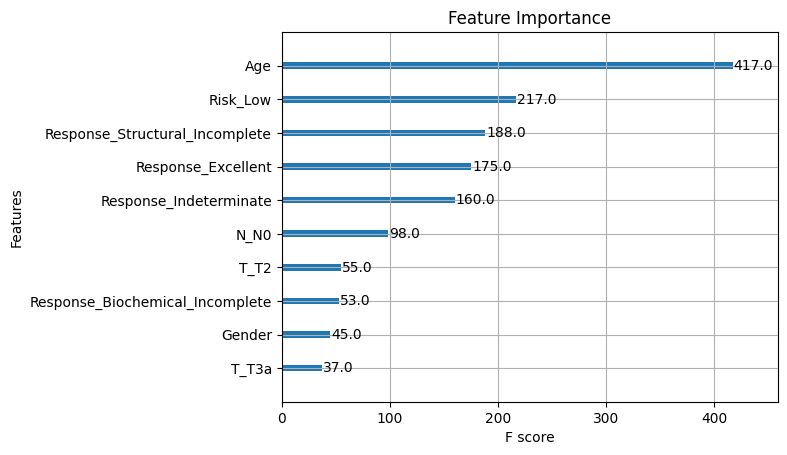

In [71]:
plt.figure(figsize=(8, 6))
plot_importance(best_model2, max_num_features=10, importance_type="weight", title="Feature Importance")
plt.show()

Now let's check the performance on the validation set. If it is much smaller than the performance on the training set, it is a sign of overfitting. Then we iterate and change the model until we have somewhat close values of performances on the train and validation sets

In [72]:
y_pred_val = best_model2.predict(X_val)
recall_score(y_val,y_pred_val)

1.0

we got a perfect score in the validation set, meaning there were no False Negatives since we are using Recall as the evaluation metric. If the dataset was bigger, this would probably not happen. Let's check if we got all cases right (if precision was 1.0 as well)

In [73]:
check = pd.DataFrame({'real':y_val,'pred':pd.Series(y_pred_val, index = y_val.index)})
check['is_equal'] = check['real'] == check['pred']
print(f'Precision Score: {precision_score(y_val,y_pred_val)}')
check[check['is_equal']==False]

Precision Score: 0.9230769230769231


,real,pred,is_equal
128,0,1,False


We can verify that precision is not 1.0 since we got a False Positive. As stated, for this specific case we rather have False Positives than False Negatives

Now let's see the score on the unseen test set

In [74]:
y_pred_test = best_model2.predict(X_test)
recall_score(y_test,y_pred_test)

0.9411764705882353

Again, let's see which cases the model got wrong

In [75]:
check = pd.DataFrame({'real':y_test,'pred':pd.Series(y_pred_test, index = y_test.index)})
check['is_equal'] = check['real'] == check['pred']
check[check['is_equal']==False]

,real,pred,is_equal
336,0,1,False
114,1,0,False


We have 1 False Negative and 1 False Positive. Let's see other metrics

The confusion matrix gives us information about both Precision and Recall

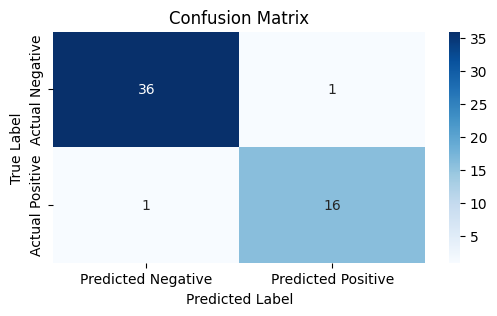

In [76]:
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=[6,3])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted Negative", "Predicted Positive"], yticklabels=["Actual Negative", "Actual Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Accuracy measures how often the classifier correctly predicts <br>
F1 score combines the Precision and Recall scores <br>
ROC_AUC score is the measure of the ability of a classifier to distinguish between classes. It is the area under the curve that plots the True Positive Rate against the False Positive Rate

In [77]:
print(f' Recall: {recall_score(y_test, y_pred_test)} \n Precision: {precision_score(y_test, y_pred_test)} \n Accuracy: {accuracy_score(y_test, y_pred_test)} \n F1 score: {f1_score(y_test, y_pred_test)} \n ROC_AUC score: {roc_auc_score(y_test, y_pred_test)}')

 Recall: 0.9411764705882353 
 Precision: 0.9411764705882353 
 Accuracy: 0.9629629629629629 
 F1 score: 0.9411764705882353 
 ROC_AUC score: 0.9570747217806042


### Some Insights

The dataset is too small and too imbalanced for the performance metrics to be credible in a real life scenario. The solution would be to either gather more data from other sources or to enlarge the dataset via synthetic data generation. <br>
In cases like this, where the consequences of False Negatives are much more damaging than the consequences of False Positives, it is better to take a more conservative approach which can lead to an apparent 'worse' score. We are basically more focused on reducing the number of False Negatives (get better recall) than on correctly predicting the binary outcome for all cases (we may get worse accuracy).